# Google Cloud Model Evaluation On Stutterance

1. Turn original transcripts into dataframes
2. Read generated transcript dataframes
3. Get Error & Stutterance count
4. Get Error & Stutterance Type ==> show which stutterance type is more prone to error
5. Calculate Correlation Score
6. Generate Heatmap
7. Summarize Trend

***

### Error Metrics
1. Net / Total Word Error Rate
2. Word Error Rate Specific After Cleaning other Stutterance Type Annotations

***

## Using Custom Kernel on SCC

SCC sometimes has the problem with installed library not importable [`module not found` error], this is an alternative.

Assuming you have a conda environment created, you would do the following:
1. `conda install -c anaconda ipykernel`
2. `python -m ipykernel install --user --name=<env name>`
3. If the new kernel cannot be found, relaunch a new SCC instance

**Remember to switch to the conda env kernel**

In [1]:
ds_transcript_path = "/projectnb/ds549/projects/AImpower/datasets/updated_annotation_deid_full"

In [2]:
!pip install pandas numpy scipy tqdm

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


---

## Word Error Rate

Objectives:
* split sequence into characters
* count:
    * deletion: missing words
    * substitutions: wrongly recognized words
    * insertions: extra words

In [3]:
def wer(candidate, reference):
    """
    Parameter(s)
    ------------
    candidate ==> generated transcript
    reference ==> dataset transcript
    """

    candidate_tokens = list(candidate)
    reference_tokens = list(reference)

    cand_len = len(candidate_tokens)
    ref_len = len(reference_tokens)

    dist_mat = np.zeros((ref_len, cand_len), dtype=int)

    for i in range(ref_len):
        dist_mat[i][0] = i
    for j in range(cand_len):
        dist_mat[0][j] = j

    for i in range(1, ref_len):
        for j in range(1, cand_len):
            if (candidate_tokens[j - 1] == reference_tokens[i - 1]):
                cost = 0
            else:
                cost = 1

            dist_mat[i][j] = min(
                dist_mat[i-1][j] + 1,
                dist_mat[i][j-1] + 1,
                dist_mat[i-1][j-1] + cost
            )
            # print(dist_mat)

    wer = dist_mat[-1][-1] / len(reference_tokens)
    return wer

***

## Imports and Data Ingestion (Google Cloud)

In [4]:
import pandas as pd
import numpy as np
import scipy
import os
from tqdm import tqdm
import re
import sys

In [5]:
net_data = pd.DataFrame(columns=["Filename", "Start_time", "End_time", "Transcript"])
net_aigenerated_data_google = pd.read_csv("/projectnb/ds549/projects/AImpower/datasets/generated-transcripts/GoogleCloud.csv", delimiter=",")

del net_aigenerated_data_google[net_aigenerated_data_google.columns[0]]

In [6]:
for folder in os.listdir(ds_transcript_path):
    if folder == "command_stats.xlsx" or folder == "command_stats.csv":
        continue
    for audio_sample in os.listdir(os.path.join(ds_transcript_path, f"{folder}")):
        if ("_A.txt" in audio_sample):
            net_data = pd.concat([net_data, pd.read_csv(os.path.join(ds_transcript_path, f"{folder}/{audio_sample}"), sep="\t", names=["Start_time", "End_time", "Transcript"]).assign(Filename=f"D{folder}_A")])
        if ("_B.txt" in audio_sample):
            net_data = pd.concat([net_data, pd.read_csv(os.path.join(ds_transcript_path, f"{folder}/{audio_sample}"), sep="\t", names=["Start_time", "End_time", "Transcript"]).assign(Filename=f"D{folder}_B")])
        if ("P" in audio_sample):
            net_data = pd.concat([net_data, pd.read_csv(os.path.join(ds_transcript_path, f"{folder}/{audio_sample}"), sep="\t", names=["Start_time", "End_time", "Transcript"]).assign(Filename=f"P{folder}")])

In [7]:
mask_pattern = r"\<.*?\>"
repetition_pattern = r"\[.*?\]"
annotation_pattern = r"/\w"


net_data = net_data.assign(Cleaned_Transcript=net_data['Transcript'].apply(lambda x: re.sub(annotation_pattern, "", re.sub(repetition_pattern, "", re.sub(mask_pattern, "", x)))))
net_data = net_data.assign(Stutterance_Count=net_data['Transcript'].apply(lambda x: len(re.findall(mask_pattern, x)) + len(re.findall(repetition_pattern, x)) + len(re.findall(annotation_pattern, x))))

In [8]:
net_data

,Filename,Start_time,End_time,Transcript,Cleaned_Transcript,Stutterance_Count
0,D0045_A,48.330,58.020,嗯，我[我/b我]现在已经工作了，我是/p一八年毕业的，然后我的专业是/p国际经济与贸易。,嗯，我现在已经工作了，我是一八年毕业的，然后我的专业是国际经济与贸易。,4
1,D0045_A,58.900,72.140,然后我现在嗯/i/p我现在的工作是/p[是]在/p[是在]<人民银行>，但是这个工作就是/p...,然后我现在嗯我现在的工作是在，但是这个工作就是可能快要就不干了。,8
2,D0045_A,74.100,81.260,嗯/i/p然后我平常的爱好是/p比较喜欢看电影，然后还喜欢打网球。,嗯然后我平常的爱好是比较喜欢看电影，然后还喜欢打网球。,3
3,D0045_A,84.930,86.320,嗯/i<overlap>结束了。,嗯结束了。,2
4,D0045_A,100.950,113.700,嗯，这个就是它[它]不是银行系统，然后它然/r后那个之所以不干，是因为就是这个，嗯/i就是现...,嗯，这个就是它不是银行系统，然后它然后那个之所以不干，是因为就是这个，嗯就是现在人民银行的县...,4
...,...,...,...,...,...,...
135,P0030,3202.732,3213.472,单曲循环歌曲最[最最]爱的为何没结果。,单曲循环歌曲最爱的为何没结果。,1
136,P0030,3216.222,3221.042,来[来]一首朴/p树的歌。,来一首朴树的歌。,2
137,P0030,3225.732,3236.142,搜[搜/r/b搜]索小灿的多/p年/p/r/b以后。,搜索小灿的多年以后。,7
138,P0030,3240.652,3253.172,播放半吨/b/r/p孙弟歌孙兄弟的歌。,播放半吨孙弟歌孙兄弟的歌。,3


In [9]:
net_aigenerated_data_google

,Filename,Start_time,End_time,GoogleCloud
0,D0001_A,2081.540000,2109.650000,我说出来就比较多需要时间哦然后那个识别的它的不就是它等你一会了那个话还没有说完还没有说出来的...
1,D0001_A,790.130000,796.580000,电视剧叫我说的话
2,D0001_A,1562.083518,1586.220000,这部剧是不怎么评判是不怎么好的评论区说拿了好惨的那个就那么情况但是就是一直输给男主角
3,D0001_A,2016.780000,2035.673559,很精准的讯飞语音还是讯飞出手救救我记得他是叫讯飞和之前就是他
4,D0001_A,1682.670000,1709.110000,一个那个是叫啥来着我忘了就是出现了然后呢他他就算了一把剑里然后就叫板那个拿那个给打杀了就是可...
...,...,...,...,...
37248,P0070,2586.616000,2589.346000,单曲循环歌曲这样而已
37249,P0070,2782.496000,2783.706000,杨幂的电影
37250,P0070,2995.296000,2998.116000,你好米亚今天的油价怎么样
37251,P0070,2604.066000,2606.656000,单曲循环歌曲琉璃光之歌


**Now we have raw data of all audio transcriptions from datasets [updated_annotation_deid_full] in `net_data` and AI predicted transcriptions in `net_aigenerated_data_google`**

***

## Google Cloud WER Analysis

In [10]:
na_count_large = 0
na_count_cleaned = 0
for index, row in tqdm(net_aigenerated_data_google.iterrows(), total=len(net_aigenerated_data_google)):

    mask_large = (
        (net_aigenerated_data_google["Filename"] == row["Filename"]) &
        (net_aigenerated_data_google["Start_time"] == row["Start_time"])
    )

    mask_net = (
        (net_data["Filename"] == row["Filename"]) &
        (net_data["Start_time"] == row["Start_time"])
    )


    large_row = net_aigenerated_data_google.loc[mask_large]
    net_row = net_data.loc[mask_net]

    if large_row.empty or net_row.empty:
        print("Skipping: One of the rows is empty.")
        continue

    google = large_row["GoogleCloud"].values[0]
    cleaned_transcript = net_row["Cleaned_Transcript"].values[0]

    if pd.isna(google) or not isinstance(google, str):
        print("Skipping due to missing or non-string Google Cloud.")
        na_count_large = na_count_large + 1
        continue
    if pd.isna(cleaned_transcript) or not isinstance(cleaned_transcript, str):
        print("Skipping due to missing or non-string Cleaned_Transcript.")
        na_count_cleaned = na_count_cleaned + 1
        continue

    try:

        wer_value = wer(google, cleaned_transcript)

        net_aigenerated_data_google.loc[mask_large, "WER"] = wer_value

        stutterance_count = net_row["Stutterance_Count"].values[0]
        net_aigenerated_data_google.loc[mask_large, "Stutterance_Count"] = stutterance_count

    except Exception as e:
        print(f'ERROR: {e}')
        print('Occurred with the following data:')
        print(large_row)
        print(net_row)

net_aigenerated_data_google = net_aigenerated_data_google.assign(NA_Count=na_count_large)
net_aigenerated_data_google = net_aigenerated_data_google.assign(NA_Cleaned_Count=na_count_cleaned)

  0%|          | 59/37253 [00:00<04:20, 142.77it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  0%|          | 94/37253 [00:00<03:54, 158.64it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  0%|          | 144/37253 [00:00<04:01, 153.69it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  0%|          | 178/37253 [00:01<03:55, 157.46it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  1%|          | 226/37253 [00:01<03:56, 156.69it/s]

Skipping due to missing or non-string Google Cloud.


  1%|          | 260/37253 [00:01<03:56, 156.41it/s]

Skipping due to missing or non-string Google Cloud.


  1%|          | 313/37253 [00:01<03:46, 163.26it/s]

Skipping due to missing or non-string Google Cloud.


  1%|          | 429/37253 [00:02<03:55, 156.07it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  1%|▏         | 530/37253 [00:03<03:45, 162.69it/s]

Skipping due to missing or non-string Google Cloud.


  2%|▏         | 564/37253 [00:03<03:50, 158.89it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  2%|▏         | 706/37253 [00:04<03:55, 155.11it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  2%|▏         | 757/37253 [00:04<03:56, 154.60it/s]

Skipping due to missing or non-string Google Cloud.


  2%|▏         | 809/37253 [00:05<03:45, 161.64it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  2%|▏         | 843/37253 [00:05<03:47, 160.10it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  2%|▏         | 877/37253 [00:05<03:46, 160.62it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  3%|▎         | 1124/37253 [00:07<03:37, 166.42it/s]

Skipping due to missing or non-string Google Cloud.


  3%|▎         | 1161/37253 [00:07<03:27, 173.75it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  3%|▎         | 1199/37253 [00:07<03:22, 177.72it/s]

Skipping due to missing or non-string Google Cloud.


  3%|▎         | 1253/37253 [00:07<03:23, 176.58it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  3%|▎         | 1288/37253 [00:08<03:47, 157.77it/s]

Skipping due to missing or non-string Google Cloud.


  4%|▎         | 1351/37253 [00:08<04:03, 147.68it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  4%|▍         | 1397/37253 [00:08<04:03, 147.12it/s]

Skipping due to missing or non-string Google Cloud.


  4%|▍         | 1444/37253 [00:09<04:09, 143.50it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  4%|▍         | 1505/37253 [00:09<04:00, 148.95it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  4%|▍         | 1566/37253 [00:10<04:04, 145.67it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  4%|▍         | 1615/37253 [00:10<03:55, 151.51it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  4%|▍         | 1648/37253 [00:10<03:51, 153.53it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  5%|▍         | 1681/37253 [00:10<03:44, 158.19it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  5%|▍         | 1771/37253 [00:11<03:25, 172.30it/s]

Skipping due to missing or non-string Google Cloud.


  5%|▍         | 1841/37253 [00:11<03:37, 162.51it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping: One of the rows is empty.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  5%|▌         | 1875/37253 [00:12<03:42, 159.32it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  5%|▌         | 1923/37253 [00:12<03:45, 156.63it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  5%|▌         | 1971/37253 [00:12<03:49, 153.81it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  5%|▌         | 1988/37253 [00:12<03:44, 157.11it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  5%|▌         | 2020/37253 [00:12<03:56, 148.81it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  6%|▌         | 2052/37253 [00:13<03:49, 153.16it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  6%|▌         | 2133/37253 [00:13<03:45, 155.50it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  6%|▌         | 2167/37253 [00:13<03:38, 160.79it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  6%|▌         | 2217/37253 [00:14<03:38, 160.18it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  6%|▌         | 2251/37253 [00:14<03:37, 161.17it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  6%|▌         | 2299/37253 [00:14<04:12, 138.29it/s]

Skipping due to missing or non-string Google Cloud.


  7%|▋         | 2473/37253 [00:16<04:01, 143.94it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  7%|▋         | 2535/37253 [00:16<03:51, 149.99it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  7%|▋         | 2585/37253 [00:16<03:41, 156.61it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  7%|▋         | 2619/37253 [00:17<03:35, 160.90it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  7%|▋         | 2654/37253 [00:17<03:32, 162.99it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  7%|▋         | 2705/37253 [00:17<03:30, 164.11it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  7%|▋         | 2739/37253 [00:17<03:29, 164.46it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  7%|▋         | 2772/37253 [00:17<04:00, 143.18it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  8%|▊         | 2802/37253 [00:18<04:03, 141.47it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  8%|▊         | 2832/37253 [00:18<04:08, 138.29it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  8%|▊         | 2860/37253 [00:18<04:13, 135.50it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  8%|▊         | 2923/37253 [00:19<03:51, 148.37it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  8%|▊         | 3034/37253 [00:19<03:52, 147.32it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  8%|▊         | 3118/37253 [00:20<04:26, 127.97it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  9%|▊         | 3227/37253 [00:21<04:17, 132.35it/s]

Skipping due to missing or non-string Google Cloud.


  9%|▉         | 3368/37253 [00:22<04:24, 128.18it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  9%|▉         | 3394/37253 [00:22<04:26, 127.21it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  9%|▉         | 3459/37253 [00:23<04:33, 123.37it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


  9%|▉         | 3498/37253 [00:23<04:40, 120.33it/s]

Skipping due to missing or non-string Google Cloud.


  9%|▉         | 3524/37253 [00:23<04:33, 123.18it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 10%|▉         | 3555/37253 [00:23<04:03, 138.17it/s]

Skipping due to missing or non-string Google Cloud.


 10%|▉         | 3619/37253 [00:24<03:39, 152.99it/s]

Skipping due to missing or non-string Google Cloud.


 10%|▉         | 3684/37253 [00:24<03:35, 156.13it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 10%|▉         | 3719/37253 [00:24<03:23, 165.02it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 10%|█         | 3756/37253 [00:25<03:14, 172.13it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 10%|█         | 3792/37253 [00:25<03:16, 170.28it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 10%|█         | 3828/37253 [00:25<03:16, 170.49it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 11%|█         | 3917/37253 [00:26<03:16, 169.23it/s]

Skipping due to missing or non-string Google Cloud.


 11%|█         | 3968/37253 [00:26<03:21, 165.52it/s]

Skipping due to missing or non-string Google Cloud.


 11%|█         | 4004/37253 [00:26<03:16, 169.28it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 11%|█         | 4058/37253 [00:26<03:12, 172.51it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 11%|█         | 4076/37253 [00:26<03:13, 171.10it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 11%|█         | 4131/37253 [00:27<03:11, 172.99it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 11%|█         | 4167/37253 [00:27<03:12, 172.10it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 11%|█▏        | 4203/37253 [00:27<03:15, 169.27it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 11%|█▏        | 4254/37253 [00:28<03:26, 159.63it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 12%|█▏        | 4287/37253 [00:28<03:36, 151.95it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 12%|█▏        | 4334/37253 [00:28<03:42, 148.16it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 12%|█▏        | 4367/37253 [00:28<03:35, 152.73it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 12%|█▏        | 4438/37253 [00:29<03:10, 172.11it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 12%|█▏        | 4477/37253 [00:29<03:02, 179.43it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 12%|█▏        | 4513/37253 [00:29<03:13, 169.58it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 12%|█▏        | 4548/37253 [00:29<03:14, 168.05it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 12%|█▏        | 4599/37253 [00:30<03:23, 160.47it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 12%|█▏        | 4616/37253 [00:30<03:24, 159.93it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 13%|█▎        | 4667/37253 [00:30<03:22, 161.06it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 13%|█▎        | 4702/37253 [00:30<03:18, 164.21it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 13%|█▎        | 4754/37253 [00:31<03:13, 167.96it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 13%|█▎        | 4824/37253 [00:31<03:09, 171.55it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 13%|█▎        | 4876/37253 [00:31<03:21, 161.06it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 13%|█▎        | 4927/37253 [00:32<03:22, 159.39it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 13%|█▎        | 4962/37253 [00:32<03:16, 164.33it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 13%|█▎        | 4997/37253 [00:32<03:12, 167.93it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 14%|█▎        | 5106/37253 [00:33<03:02, 175.86it/s]

Skipping due to missing or non-string Google Cloud.


 14%|█▍        | 5160/37253 [00:33<03:00, 177.45it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 14%|█▍        | 5247/37253 [00:34<03:17, 161.68it/s]

Skipping due to missing or non-string Google Cloud.


 14%|█▍        | 5281/37253 [00:34<03:25, 155.80it/s]

Skipping due to missing or non-string Google Cloud.


 14%|█▍        | 5330/37253 [00:34<03:24, 156.13it/s]

Skipping due to missing or non-string Google Cloud.


 15%|█▍        | 5446/37253 [00:35<03:19, 159.06it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 15%|█▍        | 5558/37253 [00:36<03:25, 154.56it/s]

Skipping due to missing or non-string Google Cloud.


 15%|█▌        | 5622/37253 [00:36<03:24, 154.51it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 15%|█▌        | 5761/37253 [00:37<04:00, 131.06it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 16%|█▌        | 5789/37253 [00:37<03:56, 133.07it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 16%|█▌        | 5836/37253 [00:38<03:36, 145.12it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 16%|█▌        | 5866/37253 [00:38<03:36, 144.95it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 16%|█▌        | 5900/37253 [00:38<03:19, 156.83it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 16%|█▌        | 5954/37253 [00:38<03:06, 167.75it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 16%|█▌        | 5988/37253 [00:39<03:15, 160.08it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 16%|█▌        | 6037/37253 [00:39<03:20, 155.74it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 16%|█▋        | 6070/37253 [00:39<03:16, 158.77it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 16%|█▋        | 6102/37253 [00:39<03:20, 155.53it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 16%|█▋        | 6134/37253 [00:40<03:20, 155.06it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 17%|█▋        | 6183/37253 [00:40<03:19, 155.42it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 17%|█▋        | 6218/37253 [00:40<03:10, 162.88it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 17%|█▋        | 6253/37253 [00:40<03:06, 165.95it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 17%|█▋        | 6290/37253 [00:40<02:56, 175.41it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 17%|█▋        | 6326/37253 [00:41<03:07, 165.24it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 17%|█▋        | 6360/37253 [00:41<03:11, 161.25it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 17%|█▋        | 6393/37253 [00:41<03:23, 151.53it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 17%|█▋        | 6454/37253 [00:42<03:38, 141.00it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 18%|█▊        | 6532/37253 [00:42<03:28, 147.15it/s]

Skipping due to missing or non-string Google Cloud.


 18%|█▊        | 6580/37253 [00:42<03:19, 153.90it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 18%|█▊        | 6615/37253 [00:43<03:09, 161.59it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 18%|█▊        | 6666/37253 [00:43<03:07, 163.45it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 18%|█▊        | 6701/37253 [00:43<03:05, 165.10it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 18%|█▊        | 6735/37253 [00:43<03:13, 157.64it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 18%|█▊        | 6783/37253 [00:44<03:15, 155.71it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 18%|█▊        | 6815/37253 [00:44<03:17, 153.88it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 18%|█▊        | 6847/37253 [00:44<03:18, 153.01it/s]

Skipping due to missing or non-string Google Cloud.


 19%|█▊        | 6914/37253 [00:45<03:10, 159.06it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 19%|█▉        | 7000/37253 [00:45<03:00, 167.18it/s]

Skipping due to missing or non-string Google Cloud.


 19%|█▉        | 7052/37253 [00:45<02:59, 168.13it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 19%|█▉        | 7104/37253 [00:46<03:00, 167.42it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 19%|█▉        | 7156/37253 [00:46<02:59, 168.01it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 19%|█▉        | 7239/37253 [00:47<03:21, 148.83it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 20%|█▉        | 7269/37253 [00:47<03:31, 141.84it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 20%|█▉        | 7314/37253 [00:47<03:30, 142.43it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 20%|█▉        | 7391/37253 [00:48<03:33, 139.91it/s]

Skipping due to missing or non-string Google Cloud.


 20%|█▉        | 7437/37253 [00:48<03:22, 146.99it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 20%|██        | 7486/37253 [00:48<03:12, 155.02it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 20%|██        | 7518/37253 [00:48<03:10, 155.98it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 20%|██        | 7550/37253 [00:49<03:12, 154.06it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 20%|██        | 7601/37253 [00:49<02:59, 164.78it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 20%|██        | 7635/37253 [00:49<03:00, 164.32it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 21%|██        | 7704/37253 [00:50<02:57, 166.12it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 21%|██        | 7876/37253 [00:51<03:13, 151.96it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 21%|██        | 7911/37253 [00:51<03:01, 161.44it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 21%|██▏       | 7946/37253 [00:51<02:58, 164.58it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 21%|██▏       | 7981/37253 [00:51<02:56, 165.39it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 22%|██▏       | 8015/37253 [00:52<03:00, 162.42it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 22%|██▏       | 8086/37253 [00:52<02:52, 169.32it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 22%|██▏       | 8123/37253 [00:52<02:47, 173.85it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 22%|██▏       | 8177/37253 [00:53<02:55, 165.60it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 22%|██▏       | 8211/37253 [00:53<02:55, 165.21it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 22%|██▏       | 8245/37253 [00:53<03:01, 159.60it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 22%|██▏       | 8278/37253 [00:53<03:03, 157.64it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 22%|██▏       | 8328/37253 [00:54<02:59, 161.23it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 22%|██▏       | 8363/37253 [00:54<02:54, 165.11it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 23%|██▎       | 8398/37253 [00:54<02:55, 164.50it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 23%|██▎       | 8433/37253 [00:54<02:52, 167.08it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 23%|██▎       | 8488/37253 [00:54<02:45, 173.34it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 23%|██▎       | 8524/37253 [00:55<02:45, 173.25it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 23%|██▎       | 8560/37253 [00:55<02:45, 172.99it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 23%|██▎       | 8595/37253 [00:55<02:56, 161.94it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 23%|██▎       | 8629/37253 [00:55<02:55, 162.77it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 23%|██▎       | 8680/37253 [00:56<02:55, 162.71it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 23%|██▎       | 8714/37253 [00:56<03:00, 157.99it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 23%|██▎       | 8746/37253 [00:56<03:12, 148.38it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 24%|██▎       | 8794/37253 [00:56<03:08, 151.36it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 24%|██▎       | 8827/37253 [00:57<03:05, 152.97it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 24%|██▎       | 8843/37253 [00:57<03:11, 148.09it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 24%|██▍       | 8888/37253 [00:57<03:20, 141.14it/s]

Skipping due to missing or non-string Google Cloud.


 24%|██▍       | 8933/37253 [00:57<03:21, 140.47it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 24%|██▍       | 9010/37253 [00:58<03:14, 144.94it/s]

Skipping due to missing or non-string Google Cloud.


 24%|██▍       | 9042/37253 [00:58<03:08, 149.59it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 24%|██▍       | 9123/37253 [00:59<02:59, 156.38it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 25%|██▍       | 9209/37253 [00:59<02:49, 165.31it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 25%|██▍       | 9259/37253 [01:00<03:02, 153.01it/s]

Skipping due to missing or non-string Google Cloud.


 25%|██▌       | 9340/37253 [01:00<03:07, 148.95it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 25%|██▌       | 9386/37253 [01:00<03:12, 144.51it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 25%|██▌       | 9434/37253 [01:01<03:03, 151.60it/s]

Skipping due to missing or non-string Google Cloud.


 25%|██▌       | 9484/37253 [01:01<02:55, 158.67it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 26%|██▌       | 9517/37253 [01:01<02:53, 159.85it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 26%|██▌       | 9569/37253 [01:02<02:48, 163.93it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 26%|██▌       | 9620/37253 [01:02<02:53, 159.26it/s]

Skipping due to missing or non-string Google Cloud.


 26%|██▌       | 9668/37253 [01:02<03:02, 151.20it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 26%|██▌       | 9750/37253 [01:03<02:54, 157.82it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 26%|██▋       | 9782/37253 [01:03<02:56, 155.40it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 27%|██▋       | 9909/37253 [01:04<03:13, 141.26it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 27%|██▋       | 9942/37253 [01:04<03:00, 150.93it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 27%|██▋       | 9993/37253 [01:04<02:52, 158.47it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 27%|██▋       | 10061/37253 [01:05<02:44, 165.69it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 27%|██▋       | 10114/37253 [01:05<02:39, 169.69it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 28%|██▊       | 10323/37253 [01:06<02:39, 169.29it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 28%|██▊       | 10359/37253 [01:06<02:35, 172.72it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 28%|██▊       | 10395/37253 [01:07<02:35, 172.94it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 28%|██▊       | 10430/37253 [01:07<02:50, 157.37it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 28%|██▊       | 10462/37253 [01:07<02:53, 154.40it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping: One of the rows is empty.


 28%|██▊       | 10494/37253 [01:07<02:59, 148.93it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 28%|██▊       | 10571/37253 [01:08<02:54, 153.11it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 29%|██▊       | 10620/37253 [01:08<02:50, 156.17it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 29%|██▊       | 10688/37253 [01:09<02:41, 164.59it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 29%|██▉       | 10722/37253 [01:09<02:47, 157.93it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 29%|██▉       | 10769/37253 [01:09<03:03, 144.68it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 29%|██▉       | 10803/37253 [01:09<02:49, 155.59it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 29%|██▉       | 10855/37253 [01:10<02:38, 166.45it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 29%|██▉       | 10892/37253 [01:10<02:31, 174.32it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 29%|██▉       | 10928/37253 [01:10<02:40, 163.85it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 30%|██▉       | 10995/37253 [01:11<02:48, 156.14it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 30%|██▉       | 11027/37253 [01:11<02:49, 154.56it/s]

Skipping due to missing or non-string Google Cloud.


 30%|██▉       | 11076/37253 [01:11<02:46, 157.06it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 30%|██▉       | 11109/37253 [01:11<02:44, 158.57it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 30%|██▉       | 11173/37253 [01:12<02:49, 154.31it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 30%|███       | 11205/37253 [01:12<02:48, 154.64it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 30%|███       | 11269/37253 [01:12<02:49, 153.53it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 30%|███       | 11303/37253 [01:13<02:43, 158.38it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 30%|███       | 11351/37253 [01:13<02:48, 154.15it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 31%|███       | 11400/37253 [01:13<02:47, 154.03it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 31%|███       | 11503/37253 [01:14<02:36, 164.93it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 31%|███       | 11537/37253 [01:14<02:34, 166.15it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 31%|███       | 11605/37253 [01:14<02:46, 154.14it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 31%|███       | 11637/37253 [01:15<02:53, 148.02it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 31%|███▏      | 11697/37253 [01:15<03:07, 136.01it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 32%|███▏      | 11742/37253 [01:15<02:59, 142.49it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 32%|███▏      | 11824/37253 [01:16<02:55, 144.92it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 32%|███▏      | 11888/37253 [01:16<02:44, 153.79it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 32%|███▏      | 11939/37253 [01:17<02:35, 162.54it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 32%|███▏      | 11973/37253 [01:17<02:42, 156.05it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 32%|███▏      | 12008/37253 [01:17<02:37, 160.44it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 32%|███▏      | 12061/37253 [01:17<02:31, 166.56it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 33%|███▎      | 12161/37253 [01:18<02:36, 160.19it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 33%|███▎      | 12213/37253 [01:18<02:31, 165.37it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 33%|███▎      | 12247/37253 [01:19<02:31, 164.83it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 33%|███▎      | 12281/37253 [01:19<02:38, 157.12it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 33%|███▎      | 12330/37253 [01:19<02:37, 158.18it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 33%|███▎      | 12363/37253 [01:19<02:36, 159.39it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 33%|███▎      | 12412/37253 [01:20<02:36, 158.60it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 33%|███▎      | 12447/37253 [01:20<02:30, 164.83it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 34%|███▎      | 12482/37253 [01:20<02:28, 167.10it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 34%|███▎      | 12534/37253 [01:20<02:29, 164.85it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 34%|███▎      | 12567/37253 [01:21<02:37, 156.81it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 34%|███▍      | 12584/37253 [01:21<02:36, 158.09it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 34%|███▍      | 12636/37253 [01:21<02:30, 163.53it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 34%|███▍      | 12687/37253 [01:21<02:28, 165.02it/s]

Skipping due to missing or non-string Google Cloud.


 34%|███▍      | 12737/37253 [01:22<02:36, 156.44it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 34%|███▍      | 12769/37253 [01:22<02:39, 153.05it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 34%|███▍      | 12817/37253 [01:22<02:41, 151.57it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 35%|███▍      | 12864/37253 [01:22<02:43, 148.95it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 35%|███▍      | 12916/37253 [01:23<02:30, 161.18it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 35%|███▍      | 12949/37253 [01:23<02:36, 155.58it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 35%|███▍      | 12981/37253 [01:23<02:44, 147.42it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 35%|███▍      | 13013/37253 [01:23<02:39, 151.51it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 35%|███▌      | 13045/37253 [01:24<02:37, 153.34it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 35%|███▌      | 13077/37253 [01:24<02:42, 148.35it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 35%|███▌      | 13124/37253 [01:24<02:40, 150.58it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 35%|███▌      | 13156/37253 [01:24<02:37, 153.40it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 35%|███▌      | 13189/37253 [01:25<02:35, 154.47it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 36%|███▌      | 13237/37253 [01:25<02:40, 149.29it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 36%|███▌      | 13272/37253 [01:25<02:32, 157.17it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 36%|███▌      | 13324/37253 [01:25<02:27, 161.69it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 36%|███▌      | 13358/37253 [01:26<02:27, 161.71it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 36%|███▌      | 13391/37253 [01:26<02:34, 154.61it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 36%|███▌      | 13423/37253 [01:26<02:33, 155.21it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 36%|███▌      | 13458/37253 [01:26<02:28, 160.63it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 36%|███▌      | 13493/37253 [01:27<02:22, 166.45it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 36%|███▋      | 13529/37253 [01:27<02:18, 171.47it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 36%|███▋      | 13565/37253 [01:27<02:15, 174.94it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 37%|███▋      | 13617/37253 [01:27<02:37, 149.61it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 37%|███▋      | 13648/37253 [01:28<02:47, 141.30it/s]

Skipping due to missing or non-string Google Cloud.


 37%|███▋      | 13694/37253 [01:28<02:40, 146.50it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 37%|███▋      | 13726/37253 [01:28<02:35, 151.69it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 37%|███▋      | 13777/37253 [01:28<02:26, 160.41it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 37%|███▋      | 13794/37253 [01:28<02:26, 160.22it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 37%|███▋      | 13846/37253 [01:29<02:24, 161.61it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 37%|███▋      | 13898/37253 [01:29<02:26, 159.27it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 37%|███▋      | 13961/37253 [01:30<02:40, 145.35it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 38%|███▊      | 14009/37253 [01:30<02:34, 150.76it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 38%|███▊      | 14063/37253 [01:30<02:18, 167.29it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 38%|███▊      | 14098/37253 [01:30<02:16, 169.65it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 38%|███▊      | 14135/37253 [01:31<02:17, 168.47it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 38%|███▊      | 14188/37253 [01:31<02:18, 166.94it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 38%|███▊      | 14225/37253 [01:31<02:11, 175.07it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 38%|███▊      | 14278/37253 [01:31<02:20, 163.32it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 38%|███▊      | 14314/37253 [01:32<02:16, 168.10it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 39%|███▊      | 14348/37253 [01:32<02:22, 160.33it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 39%|███▊      | 14398/37253 [01:32<02:25, 157.31it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 39%|███▊      | 14433/37253 [01:32<02:20, 162.76it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 39%|███▉      | 14467/37253 [01:33<02:18, 164.79it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 39%|███▉      | 14501/37253 [01:33<02:25, 156.50it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 39%|███▉      | 14550/37253 [01:33<02:24, 156.69it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 39%|███▉      | 14585/37253 [01:33<02:18, 163.32it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 39%|███▉      | 14653/37253 [01:34<02:18, 163.31it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 39%|███▉      | 14687/37253 [01:34<02:20, 160.09it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 40%|███▉      | 14741/37253 [01:34<02:11, 171.27it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 40%|███▉      | 14777/37253 [01:35<02:09, 173.64it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 40%|███▉      | 14814/37253 [01:35<02:08, 174.28it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 40%|███▉      | 14849/37253 [01:35<02:24, 154.53it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 40%|███▉      | 14881/37253 [01:35<02:28, 150.35it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 40%|████      | 14944/37253 [01:36<02:29, 148.90it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 40%|████      | 14977/37253 [01:36<02:25, 152.97it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 40%|████      | 15027/37253 [01:36<02:20, 158.47it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 40%|████      | 15060/37253 [01:36<02:22, 155.59it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 41%|████      | 15107/37253 [01:37<02:32, 145.01it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 41%|████      | 15145/37253 [01:37<02:12, 166.41it/s]

Skipping due to missing or non-string Google Cloud.


 41%|████      | 15278/37253 [01:38<01:57, 187.07it/s]

Skipping due to missing or non-string Google Cloud.


 41%|████      | 15354/37253 [01:38<01:56, 188.43it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 43%|████▎     | 16095/37253 [01:42<01:52, 187.76it/s]

Skipping due to missing or non-string Google Cloud.


 44%|████▎     | 16285/37253 [01:43<01:51, 188.19it/s]

Skipping due to missing or non-string Google Cloud.


 44%|████▍     | 16494/37253 [01:44<01:50, 187.80it/s]

Skipping due to missing or non-string Google Cloud.


 46%|████▌     | 17159/37253 [01:48<01:46, 188.58it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 48%|████▊     | 17900/37253 [01:52<01:42, 188.04it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 48%|████▊     | 17938/37253 [01:52<01:42, 188.00it/s]

Skipping due to missing or non-string Google Cloud.


 49%|████▊     | 18071/37253 [01:53<01:41, 188.55it/s]

Skipping due to missing or non-string Google Cloud.


 49%|████▉     | 18356/37253 [01:54<01:40, 187.81it/s]

Skipping due to missing or non-string Google Cloud.


 51%|█████     | 19003/37253 [01:57<01:37, 187.84it/s]

Skipping due to missing or non-string Google Cloud.


 51%|█████     | 19060/37253 [01:58<01:37, 187.13it/s]

Skipping due to missing or non-string Google Cloud.


 51%|█████▏    | 19136/37253 [01:58<01:36, 187.43it/s]

Skipping due to missing or non-string Google Cloud.


 53%|█████▎    | 19668/37253 [02:01<01:33, 187.57it/s]

Skipping due to missing or non-string Google Cloud.


 53%|█████▎    | 19706/37253 [02:01<01:33, 187.28it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 54%|█████▍    | 20182/37253 [02:04<01:30, 189.10it/s]

Skipping due to missing or non-string Google Cloud.


 54%|█████▍    | 20277/37253 [02:04<01:30, 188.38it/s]

Skipping due to missing or non-string Google Cloud.


 55%|█████▍    | 20486/37253 [02:05<01:29, 188.16it/s]

Skipping due to missing or non-string Google Cloud.


 56%|█████▋    | 21018/37253 [02:08<01:26, 186.65it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 57%|█████▋    | 21285/37253 [02:10<01:24, 188.91it/s]

Skipping due to missing or non-string Google Cloud.


 57%|█████▋    | 21323/37253 [02:10<01:24, 188.40it/s]

Skipping due to missing or non-string Google Cloud.


 58%|█████▊    | 21532/37253 [02:11<01:23, 188.04it/s]

Skipping due to missing or non-string Google Cloud.


 59%|█████▊    | 21798/37253 [02:12<01:22, 187.93it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 59%|█████▉    | 22065/37253 [02:14<01:20, 188.13it/s]

Skipping due to missing or non-string Google Cloud.


 62%|██████▏   | 23225/37253 [02:20<01:14, 188.14it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 63%|██████▎   | 23301/37253 [02:20<01:14, 186.74it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 63%|██████▎   | 23396/37253 [02:21<01:14, 186.84it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 63%|██████▎   | 23434/37253 [02:21<01:13, 187.39it/s]

Skipping due to missing or non-string Google Cloud.


 66%|██████▌   | 24631/37253 [02:28<01:07, 186.68it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 66%|██████▋   | 24707/37253 [02:28<01:06, 187.35it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 66%|██████▋   | 24745/37253 [02:28<01:06, 186.82it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 67%|██████▋   | 24802/37253 [02:28<01:06, 186.56it/s]

Skipping due to missing or non-string Google Cloud.


 67%|██████▋   | 24840/37253 [02:29<01:06, 186.06it/s]

Skipping due to missing or non-string Google Cloud.


 67%|██████▋   | 24954/37253 [02:29<01:05, 186.47it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 67%|██████▋   | 24992/37253 [02:29<01:05, 186.36it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 67%|██████▋   | 25068/37253 [02:30<01:05, 186.89it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 67%|██████▋   | 25106/37253 [02:30<01:05, 186.56it/s]

Skipping due to missing or non-string Google Cloud.


 81%|████████  | 30084/37253 [02:57<00:38, 186.77it/s]

Skipping due to missing or non-string Google Cloud.


 81%|████████  | 30198/37253 [02:57<00:37, 187.91it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 82%|████████▏ | 30369/37253 [02:58<00:36, 187.39it/s]

Skipping due to missing or non-string Google Cloud.


 82%|████████▏ | 30426/37253 [02:59<00:36, 187.69it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 82%|████████▏ | 30502/37253 [02:59<00:35, 188.16it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 82%|████████▏ | 30540/37253 [02:59<00:35, 187.67it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 82%|████████▏ | 30597/37253 [03:00<00:35, 187.82it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 82%|████████▏ | 30654/37253 [03:00<00:35, 187.59it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 83%|████████▎ | 30768/37253 [03:00<00:34, 188.01it/s]

Skipping due to missing or non-string Google Cloud.
Skipping due to missing or non-string Google Cloud.


 89%|████████▉ | 33295/37253 [03:14<00:21, 186.67it/s]

Skipping due to missing or non-string Google Cloud.


 90%|████████▉ | 33409/37253 [03:15<00:20, 187.15it/s]

Skipping due to missing or non-string Google Cloud.


 90%|█████████ | 33542/37253 [03:15<00:19, 186.88it/s]

Skipping due to missing or non-string Google Cloud.


 91%|█████████▏| 34074/37253 [03:18<00:16, 187.40it/s]

Skipping: One of the rows is empty.
Skipping: One of the rows is empty.


 93%|█████████▎| 34606/37253 [03:21<00:14, 186.61it/s]

Skipping: One of the rows is empty.


100%|██████████| 37253/37253 [03:35<00:00, 172.71it/s]


In [11]:
net_aigenerated_data_google

,Filename,Start_time,End_time,GoogleCloud,WER,Stutterance_Count,NA_Count,NA_Cleaned_Count
0,D0001_A,2081.540000,2109.650000,我说出来就比较多需要时间哦然后那个识别的它的不就是它等你一会了那个话还没有说完还没有说出来的...,0.237113,1.0,1359,0
1,D0001_A,790.130000,796.580000,电视剧叫我说的话,0.300000,1.0,1359,0
2,D0001_A,1562.083518,1586.220000,这部剧是不怎么评判是不怎么好的评论区说拿了好惨的那个就那么情况但是就是一直输给男主角,0.421875,10.0,1359,0
3,D0001_A,2016.780000,2035.673559,很精准的讯飞语音还是讯飞出手救救我记得他是叫讯飞和之前就是他,0.368421,7.0,1359,0
4,D0001_A,1682.670000,1709.110000,一个那个是叫啥来着我忘了就是出现了然后呢他他就算了一把剑里然后就叫板那个拿那个给打杀了就是可...,0.352941,8.0,1359,0
...,...,...,...,...,...,...,...,...
37248,P0070,2586.616000,2589.346000,单曲循环歌曲这样而已,0.090909,0.0,1359,0
37249,P0070,2782.496000,2783.706000,杨幂的电影,0.166667,0.0,1359,0
37250,P0070,2995.296000,2998.116000,你好米亚今天的油价怎么样,0.333333,0.0,1359,0
37251,P0070,2604.066000,2606.656000,单曲循环歌曲琉璃光之歌,0.083333,0.0,1359,0


***

In [12]:
net_aigenerated_data_google.to_csv('net_aigenerated_data_google.csv', sep=',')

## Visualization of Relationship between Stutterance Count and Word Error Rate (Google Cloud)

In [13]:
## Load data from csv if starting here

net_aigenerated_data_google = pd.read_csv('/projectnb/ds549/projects/AImpower/evaluation-googlecloud/net_aigenerated_data_google.csv', delimiter=',')

In [14]:
import matplotlib.pyplot as plt

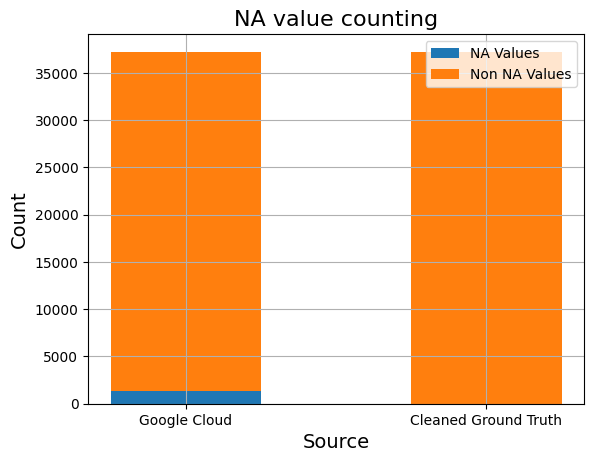

In [15]:
## Null value plots

nonnull_count_large = net_aigenerated_data_google["NA_Count"].count() - net_aigenerated_data_google.iloc[0]["NA_Count"]
null_count_large = net_aigenerated_data_google.iloc[0]["NA_Count"]

nonnull_count_cleaned = net_aigenerated_data_google["NA_Cleaned_Count"].count() - net_aigenerated_data_google.iloc[0]["NA_Cleaned_Count"]
null_count_cleaned = net_aigenerated_data_google.iloc[0]["NA_Cleaned_Count"]


data = {
    "NA Values": [null_count_large, null_count_cleaned],
    "Non NA Values": [nonnull_count_large, nonnull_count_cleaned],
}

species = (
    "Google Cloud",
    "Cleaned Ground Truth"
)

width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(2)

for na, count in data.items():
    p = ax.bar(species, count, width, label=na, bottom=bottom)
    bottom += count


ax.set_title("NA value counting", fontsize=16)
ax.set_xlabel("Source", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
ax.legend()
ax.grid(True)

plt.show()

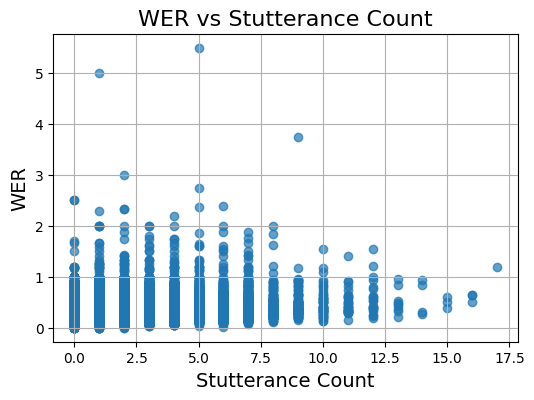

In [16]:
plt.figure(figsize=(6, 4))
plt.scatter(
    net_aigenerated_data_google["Stutterance_Count"],
    net_aigenerated_data_google["WER"],
    alpha=0.7  # Handle overlapping points
)

plt.title("WER vs Stutterance Count", fontsize=16)
plt.xlabel("Stutterance Count", fontsize=14)
plt.ylabel("WER", fontsize=14)
plt.grid(True)
plt.show()

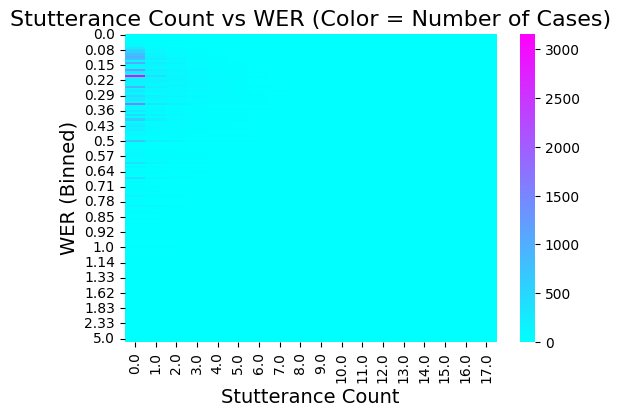

In [17]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

net_aigenerated_data_google['WER_Binned'] = np.round(net_aigenerated_data_google['WER'], 2)

grouped_data = net_aigenerated_data_google.groupby(
    ['Stutterance_Count', 'WER_Binned']
).size().reset_index(name='Count')
heatmap_data = grouped_data.pivot(index='WER_Binned', columns='Stutterance_Count', values='Count').fillna(0)

plt.figure(figsize=(6, 4))
sns.heatmap(
    heatmap_data, cmap='cool', annot=False, fmt='g', cbar=True
)

plt.title("Stutterance Count vs WER (Color = Number of Cases)", fontsize=16)
plt.xlabel("Stutterance Count", fontsize=14)
plt.ylabel("WER (Binned)", fontsize=14)

plt.show()

In [18]:
from scipy.stats import spearmanr
rho, p = spearmanr(net_aigenerated_data_google.dropna()['Stutterance_Count'], net_aigenerated_data_google.dropna()['WER'])
print(f"p-value = {p}")
print(f"rho = {rho}")

p-value = 3.8368013589584424e-242
rho = 0.17407877206435102


***

## ROUGE-N/L Scores (Semantic Evaluation) (Google Cloud)

In [19]:
pip install rouge_chinese jieba

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [20]:
from rouge_chinese import Rouge
import jieba

In [21]:
rouge = Rouge()

In [ ]:
print_ = True

for index, row in tqdm(net_aigenerated_data_google.iterrows(), total=len(net_aigenerated_data_google)):

    mask_large = (
        (net_aigenerated_data_google["Filename"] == row["Filename"]) &
        (net_aigenerated_data_google["Start_time"] == row["Start_time"])
    )

    mask_net = (
        (net_data["Filename"] == row["Filename"]) &
        (net_data["Start_time"] == row["Start_time"])
    )


    large_row = net_aigenerated_data_google.loc[mask_large]
    net_row = net_data.loc[mask_net]


    if large_row.empty or net_row.empty:
        print("Skipping: One of the rows is empty.")
        continue

    google = large_row["GoogleCloud"].values[0]
    cleaned_transcript = net_row["Cleaned_Transcript"].values[0]

    if pd.isna(google) or not isinstance(google, str):
        print("Skipping due to missing or non-string GoogleCloud.")
        continue
    if pd.isna(cleaned_transcript) or not isinstance(cleaned_transcript, str):
        print("Skipping due to missing or non-string Cleaned_Transcript.")
        continue

    try:

        scores = rouge.get_scores(' '.join(jieba.cut(google)), ' '.join(jieba.cut(cleaned_transcript)))

        net_aigenerated_data_google.loc[mask_large, "rouge1-precision"] = scores[0]["rouge-1"]["p"]
        net_aigenerated_data_google.loc[mask_large, "rouge1-recall"] = scores[0]["rouge-1"]["r"]
        net_aigenerated_data_google.loc[mask_large, "rouge1-f1"] = scores[0]["rouge-1"]["f"]


        net_aigenerated_data_google.loc[mask_large, "rouge2-precision"] = scores[0]["rouge-2"]["p"]
        net_aigenerated_data_google.loc[mask_large, "rouge2-recall"] = scores[0]["rouge-2"]["r"]
        net_aigenerated_data_google.loc[mask_large, "rouge2-f1"] = scores[0]["rouge-2"]["f"]


        net_aigenerated_data_google.loc[mask_large, "rougel-precision"] = scores[0]["rouge-l"]["p"]
        net_aigenerated_data_google.loc[mask_large, "rougel-recall"] = scores[0]["rouge-l"]["r"]
        net_aigenerated_data_google.loc[mask_large, "rougel-f1"] = scores[0]["rouge-l"]["f"]

        stutterance_count = net_row["Stutterance_Count"].values[0]
        net_aigenerated_data_google.loc[mask_large, "Stutterance_Count"] = stutterance_count

        if (print_):
            print(net_aigenerated_data_google)
            print_ = False

    except Exception as e:
        print(f'ERROR: {e}')
        print('Occurred with the following data:')
        print(large_row)
        print(net_row)

  0%|          | 0/37253 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Dumping model to file cache /scratch/291941.1.ood/jieba.cache
Loading model cost 0.611 seconds.
Prefix dict has been built successfully.
  0%|          | 29/37253 [00:00<12:34, 49.36it/s] 

       Unnamed: 0.1  Unnamed: 0 Filename   Start_time     End_time  \
0                 0           0  D0001_A  2081.540000  2109.650000   
1                 1           1  D0001_A   790.130000   796.580000   
2                 2           2  D0001_A  1562.083518  1586.220000   
3                 3           3  D0001_A  2016.780000  2035.673559   
4                 4           4  D0001_A  1682.670000  1709.110000   
...             ...         ...      ...          ...          ...   
37248         37248       37248    P0070  2586.616000  2589.346000   
37249         37249       37249    P0070  2782.496000  2783.706000   
37250         37250       37250    P0070  2995.296000  2998.116000   
37251         37251       37251    P0070  2604.066000  2606.656000   
37252         37252       37252    P0070  2434.606000  2436.576000   

                                             GoogleCloud       WER  \
0      我说出来就比较多需要时间哦然后那个识别的它的不就是它等你一会了那个话还没有说完还没有说出来的...  0.237113   
1                  

  0%|          | 57/37253 [00:01<07:13, 85.78it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  0%|          | 86/37253 [00:01<05:36, 110.42it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  0%|          | 130/37253 [00:01<04:43, 130.97it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  1%|          | 189/37253 [00:01<04:24, 140.04it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  1%|          | 219/37253 [00:02<04:24, 139.80it/s]

Skipping due to missing or non-string GoogleCloud.


  1%|          | 264/37253 [00:02<04:23, 140.51it/s]

Skipping due to missing or non-string GoogleCloud.


  1%|          | 309/37253 [00:02<04:19, 142.46it/s]

Skipping due to missing or non-string GoogleCloud.


  1%|          | 429/37253 [00:03<04:17, 143.09it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  1%|▏         | 534/37253 [00:04<04:17, 142.51it/s]

Skipping due to missing or non-string GoogleCloud.


  2%|▏         | 564/37253 [00:04<04:18, 141.70it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  2%|▏         | 707/37253 [00:05<04:18, 141.53it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  2%|▏         | 752/37253 [00:05<04:14, 143.49it/s]

Skipping due to missing or non-string GoogleCloud.


  2%|▏         | 812/37253 [00:06<04:15, 142.90it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  2%|▏         | 842/37253 [00:06<04:14, 143.01it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  2%|▏         | 872/37253 [00:06<04:11, 144.69it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  3%|▎         | 1122/37253 [00:08<04:11, 143.46it/s]

Skipping due to missing or non-string GoogleCloud.


  3%|▎         | 1152/37253 [00:08<04:08, 145.25it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  3%|▎         | 1197/37253 [00:09<04:06, 146.33it/s]

Skipping due to missing or non-string GoogleCloud.


  3%|▎         | 1257/37253 [00:09<04:05, 146.51it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  3%|▎         | 1287/37253 [00:09<04:13, 141.63it/s]

Skipping due to missing or non-string GoogleCloud.


  4%|▎         | 1345/37253 [00:10<04:17, 139.19it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  4%|▍         | 1401/37253 [00:10<04:19, 138.11it/s]

Skipping due to missing or non-string GoogleCloud.


  4%|▍         | 1445/37253 [00:10<04:17, 139.20it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  4%|▍         | 1503/37253 [00:11<04:12, 141.42it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  4%|▍         | 1561/37253 [00:11<04:15, 139.46it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  4%|▍         | 1606/37253 [00:12<04:08, 143.23it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  4%|▍         | 1652/37253 [00:12<04:01, 147.37it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  5%|▍         | 1683/37253 [00:12<03:57, 149.62it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  5%|▍         | 1715/37253 [00:12<03:59, 148.16it/s]

Skipping due to missing or non-string GoogleCloud.


  5%|▍         | 1775/37253 [00:13<04:03, 145.60it/s]

Skipping due to missing or non-string GoogleCloud.


  5%|▍         | 1835/37253 [00:13<04:06, 143.44it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping: One of the rows is empty.
Skipping due to missing or non-string GoogleCloud.


  5%|▌         | 1865/37253 [00:13<04:05, 143.99it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  5%|▌         | 1910/37253 [00:14<04:05, 144.13it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  5%|▌         | 1955/37253 [00:14<04:04, 144.34it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  5%|▌         | 1986/37253 [00:14<03:59, 147.19it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  5%|▌         | 2031/37253 [00:14<04:05, 143.53it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  6%|▌         | 2063/37253 [00:15<04:02, 145.13it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  6%|▌         | 2093/37253 [00:15<04:06, 142.68it/s]

Skipping due to missing or non-string GoogleCloud.


  6%|▌         | 2123/37253 [00:15<04:07, 142.20it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  6%|▌         | 2153/37253 [00:15<04:04, 143.31it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  6%|▌         | 2184/37253 [00:16<04:01, 145.00it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  6%|▌         | 2229/37253 [00:16<03:59, 146.17it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  6%|▌         | 2259/37253 [00:16<04:03, 143.53it/s]

Skipping due to missing or non-string GoogleCloud.


  6%|▌         | 2303/37253 [00:16<04:13, 137.60it/s]

Skipping due to missing or non-string GoogleCloud.


  7%|▋         | 2472/37253 [00:18<04:11, 138.54it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  7%|▋         | 2501/37253 [00:18<04:10, 138.99it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  7%|▋         | 2559/37253 [00:18<04:07, 140.34it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  7%|▋         | 2605/37253 [00:19<03:58, 145.05it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  7%|▋         | 2636/37253 [00:19<03:54, 147.47it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  7%|▋         | 2681/37253 [00:19<03:56, 145.96it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  7%|▋         | 2726/37253 [00:19<03:55, 146.66it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  7%|▋         | 2756/37253 [00:20<03:57, 145.19it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  8%|▊         | 2801/37253 [00:20<04:00, 143.15it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  8%|▊         | 2831/37253 [00:20<04:06, 139.67it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  8%|▊         | 2860/37253 [00:20<04:07, 138.77it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  8%|▊         | 2918/37253 [00:21<04:04, 140.38it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  8%|▊         | 3034/37253 [00:22<04:06, 138.94it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  8%|▊         | 3118/37253 [00:22<04:13, 134.47it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  9%|▊         | 3230/37253 [00:23<04:11, 135.16it/s]

Skipping due to missing or non-string GoogleCloud.


  9%|▉         | 3370/37253 [00:24<04:14, 133.36it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  9%|▉         | 3412/37253 [00:24<04:14, 132.93it/s]

Skipping due to missing or non-string GoogleCloud.


  9%|▉         | 3468/37253 [00:25<04:15, 132.46it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


  9%|▉         | 3496/37253 [00:25<04:18, 130.81it/s]

Skipping due to missing or non-string GoogleCloud.


  9%|▉         | 3524/37253 [00:25<04:14, 132.73it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 10%|▉         | 3567/37253 [00:26<04:05, 137.22it/s]

Skipping due to missing or non-string GoogleCloud.


 10%|▉         | 3624/37253 [00:26<04:02, 138.67it/s]

Skipping due to missing or non-string GoogleCloud.


 10%|▉         | 3682/37253 [00:26<03:59, 140.38it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 10%|▉         | 3713/37253 [00:27<03:49, 145.88it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 10%|█         | 3745/37253 [00:27<03:41, 151.07it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 10%|█         | 3777/37253 [00:27<03:43, 150.06it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 10%|█         | 3809/37253 [00:27<03:41, 150.67it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 10%|█         | 3855/37253 [00:28<03:47, 146.87it/s]

Skipping due to missing or non-string GoogleCloud.


 11%|█         | 3915/37253 [00:28<03:52, 143.62it/s]

Skipping due to missing or non-string GoogleCloud.


 11%|█         | 3960/37253 [00:28<03:51, 143.64it/s]

Skipping due to missing or non-string GoogleCloud.


 11%|█         | 4005/37253 [00:29<03:48, 145.73it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 11%|█         | 4052/37253 [00:29<03:42, 149.49it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 11%|█         | 4082/37253 [00:29<03:42, 148.98it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 11%|█         | 4113/37253 [00:29<03:41, 149.52it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 11%|█         | 4145/37253 [00:30<03:41, 149.72it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 11%|█         | 4175/37253 [00:30<03:42, 148.54it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 11%|█▏        | 4221/37253 [00:30<03:50, 143.58it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 11%|█▏        | 4251/37253 [00:30<03:46, 145.52it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 11%|█▏        | 4281/37253 [00:30<03:50, 142.95it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 12%|█▏        | 4311/37253 [00:31<03:54, 140.59it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 12%|█▏        | 4341/37253 [00:31<03:52, 141.62it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 12%|█▏        | 4386/37253 [00:31<03:48, 144.05it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 12%|█▏        | 4418/37253 [00:31<03:39, 149.76it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 12%|█▏        | 4450/37253 [00:32<03:33, 153.88it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 12%|█▏        | 4498/37253 [00:32<03:35, 151.90it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 12%|█▏        | 4544/37253 [00:32<03:45, 145.30it/s]

Skipping due to missing or non-string GoogleCloud.


 12%|█▏        | 4574/37253 [00:32<03:46, 144.51it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 12%|█▏        | 4619/37253 [00:33<03:48, 143.12it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 12%|█▏        | 4649/37253 [00:33<03:46, 144.00it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 13%|█▎        | 4679/37253 [00:33<03:44, 145.28it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 13%|█▎        | 4709/37253 [00:33<03:43, 145.90it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 13%|█▎        | 4739/37253 [00:34<03:43, 145.66it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 13%|█▎        | 4815/37253 [00:34<03:45, 143.54it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 13%|█▎        | 4875/37253 [00:35<03:48, 141.49it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 13%|█▎        | 4921/37253 [00:35<03:43, 144.36it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 13%|█▎        | 4952/37253 [00:35<03:41, 146.03it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 13%|█▎        | 4997/37253 [00:35<03:40, 146.31it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 14%|█▎        | 5102/37253 [00:36<03:41, 145.26it/s]

Skipping due to missing or non-string GoogleCloud.


 14%|█▍        | 5163/37253 [00:37<03:37, 147.87it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 14%|█▍        | 5238/37253 [00:37<03:45, 141.71it/s]

Skipping due to missing or non-string GoogleCloud.


 14%|█▍        | 5283/37253 [00:37<03:47, 140.37it/s]

Skipping due to missing or non-string GoogleCloud.


 14%|█▍        | 5328/37253 [00:38<03:47, 140.42it/s]

Skipping due to missing or non-string GoogleCloud.


 15%|█▍        | 5448/37253 [00:39<03:45, 141.33it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 15%|█▍        | 5553/37253 [00:39<03:44, 140.96it/s]

Skipping due to missing or non-string GoogleCloud.


 15%|█▌        | 5628/37253 [00:40<03:44, 140.69it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 15%|█▌        | 5756/37253 [00:41<03:52, 135.75it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 16%|█▌        | 5785/37253 [00:41<03:49, 137.33it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 16%|█▌        | 5830/37253 [00:41<03:40, 142.60it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 16%|█▌        | 5860/37253 [00:42<03:42, 141.22it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 16%|█▌        | 5890/37253 [00:42<03:40, 142.19it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 16%|█▌        | 5952/37253 [00:42<03:32, 147.07it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 16%|█▌        | 5997/37253 [00:42<03:35, 145.02it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 16%|█▌        | 6027/37253 [00:43<03:35, 144.78it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 16%|█▋        | 6073/37253 [00:43<03:32, 146.79it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 16%|█▋        | 6103/37253 [00:43<03:32, 146.42it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 16%|█▋        | 6133/37253 [00:43<03:33, 145.97it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 17%|█▋        | 6179/37253 [00:44<03:32, 146.05it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 17%|█▋        | 6210/37253 [00:44<03:27, 149.32it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 17%|█▋        | 6243/37253 [00:44<03:21, 153.83it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 17%|█▋        | 6278/37253 [00:44<03:11, 161.73it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 17%|█▋        | 6312/37253 [00:45<03:15, 158.43it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 17%|█▋        | 6344/37253 [00:45<03:27, 149.29it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 17%|█▋        | 6389/37253 [00:45<03:34, 143.76it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 17%|█▋        | 6447/37253 [00:46<03:44, 137.37it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 18%|█▊        | 6532/37253 [00:46<03:42, 138.27it/s]

Skipping due to missing or non-string GoogleCloud.


 18%|█▊        | 6577/37253 [00:46<03:35, 142.39it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 18%|█▊        | 6607/37253 [00:47<03:33, 143.74it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 18%|█▊        | 6652/37253 [00:47<03:33, 143.06it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 18%|█▊        | 6698/37253 [00:47<03:29, 146.07it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 18%|█▊        | 6743/37253 [00:48<03:29, 145.95it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 18%|█▊        | 6773/37253 [00:48<03:29, 145.55it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 18%|█▊        | 6818/37253 [00:48<03:27, 146.46it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 18%|█▊        | 6848/37253 [00:48<03:33, 142.73it/s]

Skipping due to missing or non-string GoogleCloud.


 19%|█▊        | 6909/37253 [00:49<03:32, 143.02it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 19%|█▉        | 6999/37253 [00:49<03:30, 143.53it/s]

Skipping due to missing or non-string GoogleCloud.


 19%|█▉        | 7044/37253 [00:50<03:29, 143.91it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 19%|█▉        | 7105/37253 [00:50<03:27, 145.53it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 19%|█▉        | 7151/37253 [00:50<03:25, 146.52it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 19%|█▉        | 7241/37253 [00:51<03:32, 141.48it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 20%|█▉        | 7271/37253 [00:51<03:33, 140.17it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 20%|█▉        | 7316/37253 [00:52<03:33, 140.21it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 20%|█▉        | 7391/37253 [00:52<03:34, 139.15it/s]

Skipping due to missing or non-string GoogleCloud.


 20%|█▉        | 7435/37253 [00:52<03:31, 141.04it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 20%|██        | 7465/37253 [00:53<03:29, 142.11it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 20%|██        | 7510/37253 [00:53<03:27, 143.59it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 20%|██        | 7540/37253 [00:53<03:27, 143.27it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 20%|██        | 7570/37253 [00:53<03:26, 143.48it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 20%|██        | 7615/37253 [00:54<03:24, 144.75it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 21%|██        | 7660/37253 [00:54<03:26, 143.63it/s]

Skipping due to missing or non-string GoogleCloud.


 21%|██        | 7705/37253 [00:54<03:24, 144.71it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 21%|██        | 7735/37253 [00:55<03:28, 141.82it/s]

Skipping due to missing or non-string GoogleCloud.


 21%|██        | 7863/37253 [00:55<03:32, 138.42it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 21%|██        | 7895/37253 [00:56<03:21, 145.39it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 21%|██▏       | 7940/37253 [00:56<03:21, 145.33it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 21%|██▏       | 7970/37253 [00:56<03:21, 145.42it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 21%|██▏       | 8000/37253 [00:56<03:20, 145.80it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 22%|██▏       | 8045/37253 [00:57<03:22, 144.33it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 22%|██▏       | 8075/37253 [00:57<03:20, 145.36it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 22%|██▏       | 8121/37253 [00:57<03:18, 147.01it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 22%|██▏       | 8166/37253 [00:58<03:21, 144.70it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 22%|██▏       | 8211/37253 [00:58<03:17, 147.13it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 22%|██▏       | 8241/37253 [00:58<03:19, 145.57it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 22%|██▏       | 8271/37253 [00:58<03:21, 143.87it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 22%|██▏       | 8332/37253 [00:59<03:20, 144.31it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 22%|██▏       | 8362/37253 [00:59<03:18, 145.56it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 23%|██▎       | 8392/37253 [00:59<03:16, 146.72it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 23%|██▎       | 8437/37253 [00:59<03:16, 146.28it/s]

Skipping due to missing or non-string GoogleCloud.


 23%|██▎       | 8468/37253 [01:00<03:15, 147.05it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 23%|██▎       | 8499/37253 [01:00<03:15, 146.86it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 23%|██▎       | 8545/37253 [01:00<03:13, 148.32it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 23%|██▎       | 8577/37253 [01:00<03:10, 150.44it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 23%|██▎       | 8624/37253 [01:01<03:12, 148.56it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 23%|██▎       | 8669/37253 [01:01<03:15, 146.55it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 23%|██▎       | 8699/37253 [01:01<03:13, 147.51it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 23%|██▎       | 8744/37253 [01:01<03:20, 141.99it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 24%|██▎       | 8789/37253 [01:02<03:19, 142.85it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 24%|██▎       | 8819/37253 [01:02<03:19, 142.87it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 24%|██▍       | 8849/37253 [01:02<03:23, 139.86it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 24%|██▍       | 8877/37253 [01:02<03:26, 137.12it/s]

Skipping due to missing or non-string GoogleCloud.


 24%|██▍       | 8934/37253 [01:03<03:26, 137.30it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 24%|██▍       | 9006/37253 [01:03<03:23, 138.75it/s]

Skipping due to missing or non-string GoogleCloud.


 24%|██▍       | 9035/37253 [01:04<03:21, 139.94it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 24%|██▍       | 9122/37253 [01:04<03:17, 142.48it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 25%|██▍       | 9213/37253 [01:05<03:12, 145.30it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 25%|██▍       | 9258/37253 [01:05<03:19, 140.13it/s]

Skipping due to missing or non-string GoogleCloud.


 25%|██▌       | 9347/37253 [01:06<03:19, 139.54it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 25%|██▌       | 9375/37253 [01:06<03:22, 138.00it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 25%|██▌       | 9446/37253 [01:07<03:20, 138.88it/s]

Skipping due to missing or non-string GoogleCloud.


 25%|██▌       | 9476/37253 [01:07<03:17, 140.98it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 26%|██▌       | 9521/37253 [01:07<03:14, 142.73it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 26%|██▌       | 9566/37253 [01:07<03:12, 144.18it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 26%|██▌       | 9626/37253 [01:08<03:16, 140.84it/s]

Skipping due to missing or non-string GoogleCloud.


 26%|██▌       | 9671/37253 [01:08<03:13, 142.79it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 26%|██▌       | 9746/37253 [01:09<03:12, 142.59it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 26%|██▌       | 9761/37253 [01:09<03:13, 142.18it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 26%|██▋       | 9806/37253 [01:09<03:13, 141.77it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 27%|██▋       | 9906/37253 [01:10<03:20, 136.37it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 27%|██▋       | 9951/37253 [01:10<03:12, 141.89it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 27%|██▋       | 9981/37253 [01:10<03:10, 143.47it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 27%|██▋       | 10056/37253 [01:11<03:08, 144.52it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 27%|██▋       | 10087/37253 [01:11<03:07, 144.89it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 27%|██▋       | 10118/37253 [01:11<03:05, 146.27it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 28%|██▊       | 10313/37253 [01:13<03:07, 143.48it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 28%|██▊       | 10344/37253 [01:13<03:03, 146.86it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 28%|██▊       | 10374/37253 [01:13<03:02, 147.37it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 28%|██▊       | 10419/37253 [01:13<03:05, 144.83it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 28%|██▊       | 10464/37253 [01:14<03:05, 144.23it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 28%|██▊       | 10494/37253 [01:14<03:07, 143.01it/s]

Skipping: One of the rows is empty.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 28%|██▊       | 10568/37253 [01:14<03:10, 140.31it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 28%|██▊       | 10613/37253 [01:15<03:06, 142.55it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 29%|██▊       | 10674/37253 [01:15<03:03, 144.75it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 29%|██▊       | 10706/37253 [01:15<02:57, 149.52it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 29%|██▉       | 10766/37253 [01:16<03:08, 140.23it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 29%|██▉       | 10797/37253 [01:16<03:03, 144.03it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 29%|██▉       | 10827/37253 [01:16<03:03, 144.36it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 29%|██▉       | 10875/37253 [01:17<02:50, 154.45it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 29%|██▉       | 10907/37253 [01:17<02:55, 150.40it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 29%|██▉       | 10938/37253 [01:17<03:00, 145.78it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 30%|██▉       | 10998/37253 [01:17<03:01, 144.68it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 30%|██▉       | 11028/37253 [01:18<03:04, 142.44it/s]

Skipping due to missing or non-string GoogleCloud.


 30%|██▉       | 11073/37253 [01:18<03:06, 140.68it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 30%|██▉       | 11103/37253 [01:18<03:04, 141.49it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 30%|██▉       | 11163/37253 [01:19<03:05, 140.53it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 30%|███       | 11193/37253 [01:19<03:04, 140.99it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 30%|███       | 11268/37253 [01:19<03:03, 141.66it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 30%|███       | 11298/37253 [01:19<03:01, 142.76it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 30%|███       | 11358/37253 [01:20<03:04, 140.26it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 31%|███       | 11387/37253 [01:20<03:05, 139.38it/s]

Skipping due to missing or non-string GoogleCloud.


 31%|███       | 11417/37253 [01:20<03:04, 140.29it/s]

Skipping due to missing or non-string GoogleCloud.


 31%|███       | 11492/37253 [01:21<02:58, 144.67it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 31%|███       | 11537/37253 [01:21<02:57, 145.20it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 31%|███       | 11598/37253 [01:22<02:59, 142.63it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 31%|███▏      | 11643/37253 [01:22<03:01, 141.28it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 31%|███▏      | 11700/37253 [01:22<03:09, 135.05it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 31%|███▏      | 11730/37253 [01:23<03:04, 138.54it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 32%|███▏      | 11831/37253 [01:23<03:02, 139.21it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 32%|███▏      | 11890/37253 [01:24<02:57, 142.74it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 32%|███▏      | 11935/37253 [01:24<02:55, 143.86it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 32%|███▏      | 11980/37253 [01:24<02:56, 142.94it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 32%|███▏      | 12011/37253 [01:25<02:51, 146.87it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 32%|███▏      | 12058/37253 [01:25<02:45, 152.16it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 33%|███▎      | 12165/37253 [01:26<02:52, 145.63it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 33%|███▎      | 12211/37253 [01:26<02:48, 148.93it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 33%|███▎      | 12242/37253 [01:26<02:46, 150.34it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 33%|███▎      | 12288/37253 [01:26<02:55, 142.43it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 33%|███▎      | 12333/37253 [01:27<02:51, 144.95it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 33%|███▎      | 12363/37253 [01:27<02:51, 144.71it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 33%|███▎      | 12393/37253 [01:27<02:50, 145.60it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 33%|███▎      | 12439/37253 [01:27<02:49, 146.78it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 33%|███▎      | 12470/37253 [01:28<02:48, 147.18it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 34%|███▎      | 12515/37253 [01:28<02:49, 146.02it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 34%|███▎      | 12545/37253 [01:28<02:50, 145.31it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 34%|███▍      | 12575/37253 [01:28<02:51, 144.11it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 34%|███▍      | 12635/37253 [01:29<02:51, 143.67it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 34%|███▍      | 12680/37253 [01:29<02:50, 143.72it/s]

Skipping due to missing or non-string GoogleCloud.


 34%|███▍      | 12725/37253 [01:29<02:52, 142.16it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 34%|███▍      | 12770/37253 [01:30<02:51, 142.80it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 34%|███▍      | 12830/37253 [01:30<02:53, 140.85it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 35%|███▍      | 12860/37253 [01:30<02:54, 139.60it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 35%|███▍      | 12892/37253 [01:31<02:45, 147.54it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 35%|███▍      | 12923/37253 [01:31<02:43, 149.16it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 35%|███▍      | 12968/37253 [01:31<02:48, 144.40it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 35%|███▍      | 13013/37253 [01:31<02:48, 143.45it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 35%|███▌      | 13043/37253 [01:32<02:47, 144.87it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 35%|███▌      | 13073/37253 [01:32<02:46, 144.95it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 35%|███▌      | 13118/37253 [01:32<02:46, 144.99it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 35%|███▌      | 13149/37253 [01:32<02:44, 146.92it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 35%|███▌      | 13180/37253 [01:33<02:43, 147.24it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 36%|███▌      | 13241/37253 [01:33<02:44, 145.81it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 36%|███▌      | 13272/37253 [01:33<02:43, 146.68it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 36%|███▌      | 13318/37253 [01:34<02:40, 148.78it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 36%|███▌      | 13349/37253 [01:34<02:38, 150.85it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 36%|███▌      | 13380/37253 [01:34<02:43, 146.36it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 36%|███▌      | 13425/37253 [01:34<02:45, 144.16it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 36%|███▌      | 13455/37253 [01:34<02:44, 144.35it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 36%|███▌      | 13485/37253 [01:35<02:42, 145.94it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 36%|███▋      | 13517/37253 [01:35<02:37, 150.24it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 36%|███▋      | 13549/37253 [01:35<02:35, 152.64it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 36%|███▋      | 13597/37253 [01:35<02:43, 144.58it/s]

Skipping due to missing or non-string GoogleCloud.


 37%|███▋      | 13627/37253 [01:36<02:47, 140.85it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 37%|███▋      | 13657/37253 [01:36<02:50, 138.17it/s]

Skipping due to missing or non-string GoogleCloud.


 37%|███▋      | 13687/37253 [01:36<02:46, 141.78it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 37%|███▋      | 13718/37253 [01:36<02:44, 143.36it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 37%|███▋      | 13763/37253 [01:37<02:42, 144.14it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 37%|███▋      | 13793/37253 [01:37<02:43, 143.89it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 37%|███▋      | 13823/37253 [01:37<02:41, 144.70it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 37%|███▋      | 13869/37253 [01:37<02:40, 145.36it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 37%|███▋      | 13899/37253 [01:38<02:41, 144.52it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 38%|███▊      | 13974/37253 [01:38<02:45, 140.93it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 38%|███▊      | 14004/37253 [01:38<02:42, 142.70it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 38%|███▊      | 14035/37253 [01:39<02:39, 145.14it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 38%|███▊      | 14083/37253 [01:39<02:35, 149.32it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 38%|███▊      | 14114/37253 [01:39<02:32, 151.64it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 38%|███▊      | 14193/37253 [01:40<02:32, 151.15it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 38%|███▊      | 14225/37253 [01:40<02:28, 154.97it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 38%|███▊      | 14257/37253 [01:40<02:32, 150.62it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 38%|███▊      | 14288/37253 [01:40<02:34, 148.67it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 38%|███▊      | 14322/37253 [01:40<02:27, 155.58it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 39%|███▊      | 14354/37253 [01:41<02:27, 155.44it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 39%|███▊      | 14386/37253 [01:41<02:30, 152.12it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 39%|███▊      | 14418/37253 [01:41<02:27, 154.74it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 39%|███▉      | 14466/37253 [01:41<02:31, 150.40it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 39%|███▉      | 14498/37253 [01:42<02:34, 146.95it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 39%|███▉      | 14543/37253 [01:42<02:38, 143.51it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 39%|███▉      | 14573/37253 [01:42<02:35, 145.60it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 39%|███▉      | 14618/37253 [01:42<02:37, 143.74it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 39%|███▉      | 14664/37253 [01:43<02:36, 144.67it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 39%|███▉      | 14709/37253 [01:43<02:35, 144.56it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 40%|███▉      | 14740/37253 [01:43<02:32, 147.57it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 40%|███▉      | 14786/37253 [01:44<02:31, 148.64it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 40%|███▉      | 14816/37253 [01:44<02:31, 147.80it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 40%|███▉      | 14846/37253 [01:44<02:36, 143.43it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 40%|███▉      | 14892/37253 [01:44<02:36, 142.70it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 40%|████      | 14937/37253 [01:45<02:36, 142.77it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 40%|████      | 14968/37253 [01:45<02:32, 145.94it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 40%|████      | 15013/37253 [01:45<02:34, 144.19it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 40%|████      | 15059/37253 [01:45<02:31, 146.14it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 41%|████      | 15104/37253 [01:46<02:38, 139.63it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 41%|████      | 15150/37253 [01:46<02:32, 145.17it/s]

Skipping due to missing or non-string GoogleCloud.


 41%|████      | 15271/37253 [01:47<02:28, 147.99it/s]

Skipping due to missing or non-string GoogleCloud.


 41%|████      | 15363/37253 [01:48<02:26, 148.99it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 43%|████▎     | 16083/37253 [01:52<02:23, 147.62it/s]

Skipping due to missing or non-string GoogleCloud.


 44%|████▎     | 16294/37253 [01:54<02:21, 148.23it/s]

Skipping due to missing or non-string GoogleCloud.


 44%|████▍     | 16489/37253 [01:55<02:20, 147.63it/s]

Skipping due to missing or non-string GoogleCloud.


 46%|████▌     | 17151/37253 [02:00<02:15, 148.62it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 48%|████▊     | 17887/37253 [02:05<02:10, 148.45it/s]

Skipping due to missing or non-string GoogleCloud.
Skipping due to missing or non-string GoogleCloud.


 48%|████▊     | 17932/37253 [02:05<02:10, 147.90it/s]

Skipping due to missing or non-string GoogleCloud.


 48%|████▊     | 18067/37253 [02:06<02:09, 147.83it/s]

Skipping due to missing or non-string GoogleCloud.


 49%|████▉     | 18353/37253 [02:08<02:07, 147.86it/s]

Skipping due to missing or non-string GoogleCloud.


 51%|█████     | 18989/37253 [02:12<02:04, 146.39it/s]

Skipping due to missing or non-string GoogleCloud.


 51%|█████     | 19050/37253 [02:13<02:03, 147.33it/s]

Skipping due to missing or non-string GoogleCloud.


 51%|█████▏    | 19125/37253 [02:13<02:02, 147.51it/s]

Skipping due to missing or non-string GoogleCloud.


 52%|█████▏    | 19395/37253 [02:15<02:00, 147.70it/s]

In [ ]:
net_aigenerated_data_google

***

In [ ]:
net_aigenerated_data_google.to_csv('net_aigenerated_data_google.csv', sep=',')

## Visualization of Relationship between Stutterance Count and Rouge Scores (Google Cloud)

In [ ]:
## Load data from csv if starting here

net_aigenerated_data_google = pd.read_csv('/projectnb/ds549/projects/AImpower/evaluation-googlecloud/net_aigenerated_data_google.csv', delimiter=',')

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(
    net_aigenerated_data_google["Stutterance_Count"],
    net_aigenerated_data_google["rouge1-precision"],
    facecolors="none", edgecolors='r',
    marker="8",
    alpha=0.7  # Handle overlapping points
)

plt.scatter(
    net_aigenerated_data_google["Stutterance_Count"],
    net_aigenerated_data_google["rouge1-recall"],
    facecolors="none", edgecolors='g',
    marker="^",
    alpha=0.7  # Handle overlapping points
)

plt.scatter(
    net_aigenerated_data_google["Stutterance_Count"],
    net_aigenerated_data_google["rouge1-f1"],
    facecolors="none", edgecolors='b',
    marker=".",
    alpha=0.7  # Handle overlapping points
)

plt.title("Rouge-1 vs Stutterance Count", fontsize=16)
plt.xlabel("Stutterance Count", fontsize=14)
plt.ylabel("Rouge Score", fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(
    net_aigenerated_data_google["Stutterance_Count"],
    net_aigenerated_data_google["rouge2-precision"],
    facecolors="none", edgecolors='r',
    marker="8",
    alpha=0.7  # Handle overlapping points
)

plt.scatter(
    net_aigenerated_data_google["Stutterance_Count"],
    net_aigenerated_data_google["rouge2-recall"],
    facecolors="none", edgecolors='g',
    marker="^",
    alpha=0.7  # Handle overlapping points
)

plt.scatter(
    net_aigenerated_data_google["Stutterance_Count"],
    net_aigenerated_data_google["rouge2-f1"],
    facecolors="none", edgecolors='b',
    marker=".",
    alpha=0.7  # Handle overlapping points
)

plt.title("Rouge-2 vs Stutterance Count", fontsize=16)
plt.xlabel("Stutterance Count", fontsize=14)
plt.ylabel("Rouge Score", fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(
    net_aigenerated_data_google["Stutterance_Count"],
    net_aigenerated_data_google["rougel-precision"],
    facecolors="none", edgecolors='r',
    marker="8",
    alpha=0.7  # Handle overlapping points
)

plt.scatter(
    net_aigenerated_data_google["Stutterance_Count"],
    net_aigenerated_data_google["rougel-recall"],
    facecolors="none", edgecolors='g',
    marker="^",
    alpha=0.7  # Handle overlapping points
)

plt.scatter(
    net_aigenerated_data_google["Stutterance_Count"],
    net_aigenerated_data_google["rougel-f1"],
    facecolors="none", edgecolors='b',
    marker=".",
    alpha=0.7  # Handle overlapping points
)

plt.title("Rouge-L vs Stutterance Count", fontsize=16)
plt.xlabel("Stutterance Count", fontsize=14)
plt.ylabel("Rouge Score", fontsize=14)
plt.grid(True)
plt.show()

## Correlations between Stuttering and Rouge Scores (Google Cloud)

In [ ]:
from scipy.stats import spearmanr
rho, p = spearmanr(net_aigenerated_data_google.dropna()['Stutterance_Count'], net_aigenerated_data_google.dropna()['rouge1-precision'])
print(f"p-value [stuttering count & rouge-1 precision] = {p}")
print(f"rho [stuttering count & rouge-1 precision] = {rho}")

rho, p = spearmanr(net_aigenerated_data_google.dropna()['Stutterance_Count'], net_aigenerated_data_google.dropna()['rouge1-recall'])
print(f"p-value [stuttering count & rouge-1 recall] = {p}")
print(f"rho [stuttering count & rouge-1 recall] = {rho}")

rho, p = spearmanr(net_aigenerated_data_google.dropna()['Stutterance_Count'], net_aigenerated_data_google.dropna()['rouge1-f1'])
print(f"p-value [stuttering count & rouge-1 f1] = {p}")
print(f"rho [stuttering count & rouge-1 f1] = {rho}")

***
***
***